<a href="https://colab.research.google.com/github/aeizaguerri/Tweet_Classification/blob/main/Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: profner/subtask-1/test-background-txt-files/1243953060050763778.txt  
  inflating: profner/subtask-1/test-background-txt-files/1243988693947486209.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244173600753618945.txt  
  inflating: profner/subtask-1/test-background-txt-files/1244319340062822405.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247000104193712129.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247263989249212416.txt  
  inflating: profner/subtask-1/test-background-txt-files/1247465550931988482.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249075777544556545.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249253729720766466.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249964965546668034.txt  
  inflating: profner/subtask-1/test-background-txt-files/1249980196838682624.txt  
  inflating: profner/subta

Funciones de carga y preparación de datos

In [ ]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i, encoding='utf8') as f: #Añadido encoding = UTF-8 para poder usar las GPUs en colab
      output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

## 0. Imports


In [ ]:
#Instalación de librerías
!pip install emoji_extractor
!pip install emoji
!pip install unidecode
!pip install textblob
!pip install stop-words
#Descarga de modelos
!python -m spacy download es_core_news_sm

#Download emoji sentiment
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for emoji_extractor: filename=emoji_extractor-2.0.0-py3-none-any.whl size=64157 sha256=b96d7ea2b8208d9584508df9eff23d0ada3eb4eb17bf3b4cda51df7087f00b23
  Stored in directory: /root/.cache/pip/wheels/14/89/95/33d1b161e1daa8fb2dec089e887d3620d3a318fdb0798e9f58
Successfully built emoji_extractor
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234911 sha256=601d358e6cca1a5e7af918cc1b86b1a4186451c539a0fc837af3b2191d852430
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, htt

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import re
import numpy as np
from nltk import word_tokenize, pos_tag
from nltk.tokenize import TweetTokenizer
from stop_words import get_stop_words #Lista de stopwords mas extensa que la de nltk

#Matplotlib y seaborn
import matplotlib.pyplot as plt
import seaborn as sns

#Emojis
from emoji_extractor.extract import Extractor
from textblob import TextBlob
from textblob import Word 
import emoji

#Spacy
import spacy
from spacy.lang.es.examples import sentences 

#Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import scipy as sp

#Rebalanceo de daltos
from imblearn.over_sampling import SMOTE

#Modelado
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import xgboost 
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#MétricaS
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, f1_score

#Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [ ]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)

In [ ]:
datos_ejercicio.head()

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train


## 2. Análisis exploratorio

* Comprobando el número de documentos y la presencia de duplicados

In [ ]:
print(f'El conjunto de datos posee {datos_ejercicio.shape[0]} documentos')

print(f'En el dataset hay {np.sum(datos_ejercicio.duplicated(subset=["tweet_id"]))} duplicados')

El conjunto de datos posee 8000 documentos
En el dataset hay 0 duplicados


* Búsqueda de valores vacíos

In [ ]:
print("Hay {} valores vacíos en el cuerpo del tweet y {} valores vacíos en las etiquetas en los datos".format(np.sum(datos_ejercicio.isnull())[0],
                                                                                                        np.sum(datos_ejercicio.isnull())[1]))

Hay 0 valores vacíos en el cuerpo del tweet y 0 valores vacíos en las etiquetas en los datos


* Comprobación de la cantidad de documentos en cada clase

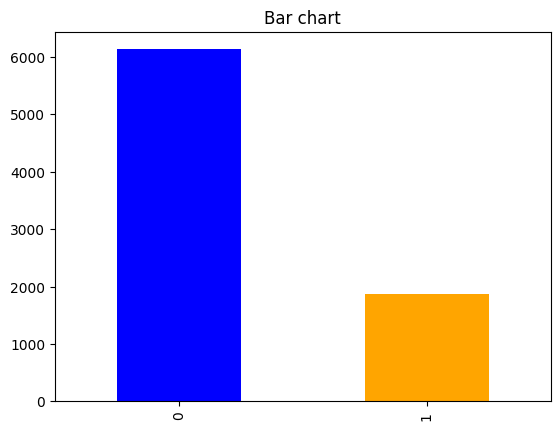

In [ ]:
ax, fig = plt.subplots()
etiquetas = datos_ejercicio.label.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

Las clases se encuentran bastante desbalanceadas, lo que podría ser un problema de cara al modelado

* Distribución de la longitud de los tweets

In [ ]:
datos_ejercicio["char_len"] = datos_ejercicio["tweet_text"].apply(lambda x: len(x))

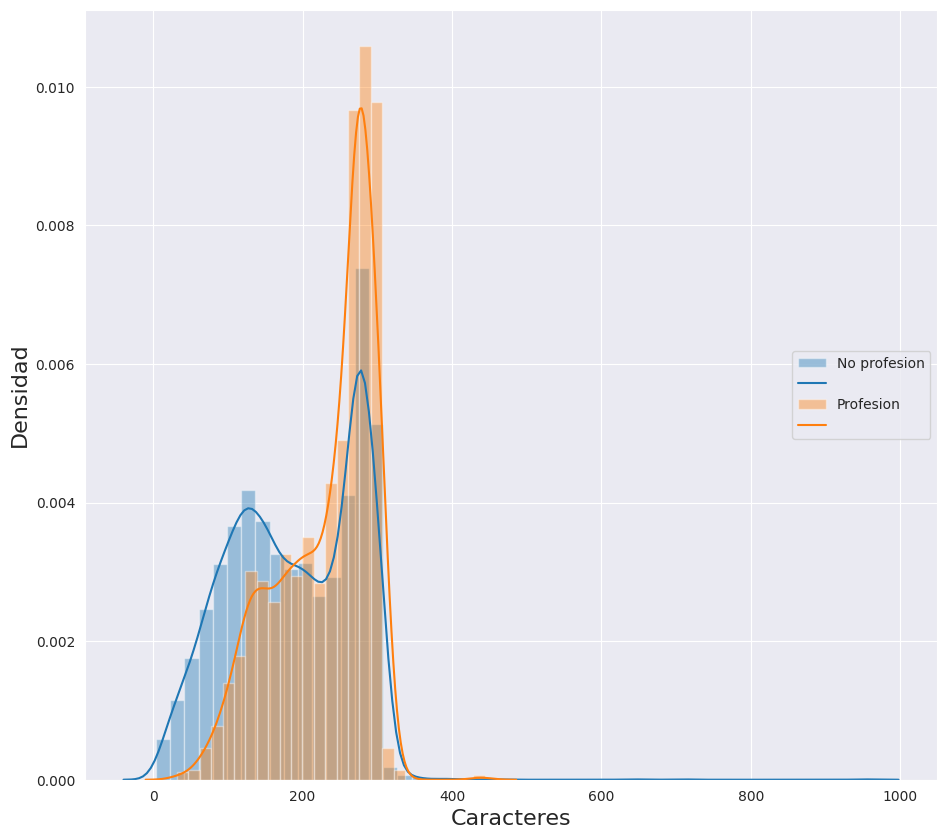

In [ ]:
fig = plt.figure(figsize=(11,10))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(datos_ejercicio[datos_ejercicio["label"]==0].char_len, hist=True, label="No profesion")
plt2 = sns.distplot(datos_ejercicio[datos_ejercicio["label"]==1].char_len, hist=True, label="Profesion")
plt.legend(labels=['No profesion',"",'Profesion',""], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

Parece que los tweets que mencionan profesiones contienen mayor cantidad de caracteres, sin embargo, ambas distribuciones se encuentran muy superpuestas, por lo que la diferencicacion de ellas por la longitud de los textos no parece un método sencillo a proirí

## 3. Preprocesado y Normalización

### Emojis

In [ ]:
# Preparar diccionario de emojis
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis negativos y entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

In [ ]:
emoji_sent_dict = load_emoji_sentiment("Emoji_Sentiment_Data_v1.0.csv")

In [ ]:
# Función para extraer emojis del texto en formato lista
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

In [ ]:
# Eliminar los emojis de un texto
def clean_emoji(text):
    # Poner todos los comandos de http://www.unicode.org/Public/emoji/1.0/emoji-data.txt
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2

In [ ]:
# Calcula el sentimiento de los emojis de una lista utilizando el diccionario
# de emoji sentiment score generado previamente con la función load_emoji_sentiment()
# Se puede extraer el valor de positividad de los emojis con la option "positive"
# Se puede extraer el valor de neutralidad de los emojis con la option "neutral""  
# Se puede extraer el valor de e negatividad de los emojis con la option "negative""  

def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e: 
      continue
  return output

In [ ]:
datos_ejercicio["emojis"] = datos_ejercicio['tweet_text'].apply(lambda x: extract_emojis(x))

In [ ]:
datos_ejercicio['emojis']

0        []
1        []
2        []
3        []
4        []
       ... 
7995     []
7996     []
7997     []
7998    [🤮]
7999    [🤣]
Name: emojis, Length: 8000, dtype: object

In [ ]:
datos_ejercicio["sent_emoji_pos"] = datos_ejercicio["emojis"].apply(lambda x: get_emoji_sentiment(x, "positive"))
datos_ejercicio["sent_emoji_neu"] = datos_ejercicio["emojis"].apply(lambda x: get_emoji_sentiment(x, "neutral"))
datos_ejercicio["sent_emoji_neg"] = datos_ejercicio["emojis"].apply(lambda x: get_emoji_sentiment(x, "negative"))

In [ ]:
datos_ejercicio["sent_emoji_pos"].describe()

count    8000.000000
mean        0.116440
std         0.327388
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.968292
Name: sent_emoji_pos, dtype: float64

### Preprocesado

In [ ]:
# Tokenizar los tweets con el tokenizador "TweetTokenizer" de NLTK
def tokenize(texto):
  tweet_tokenizer = TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(texto)
  return tokens_list

# Quitar stop words de una lista de tokens
def quitar_stopwords(tokens):
    stop_words = get_stop_words('spanish') #Utilizo esta lista que es mas extensa que la de NLTK
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación de una lista de tokens
# (nos quedamos sólo lo alfanumérico en este caso)
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words

#Transformar a minusculas
def minusculas(tokens):
  return [word.lower() for word in tokens]

# Lemmatization de los tokens. Devuelve una string entera para hacer la tokenización
# con NLTK
nlp = spacy.load("es_core_news_sm", disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    #Elimino lemmas que tengan una longitud inferior a 2
    mytokens = [lemma for lemma in mytokens if len(lemma)>=2]
    # Extraemos el text en una string
    return " ".join(mytokens)

In [ ]:
# Quitar emojis de los textos
datos_ejercicio["tweet_text_processed"] = datos_ejercicio["tweet_text"].apply(lambda x: clean_emoji(x))

In [ ]:
#Tokenizado
datos_ejercicio["tokenized"] = datos_ejercicio["tweet_text_processed"].apply(lambda x: tokenize(x))

In [ ]:
#Quitar minusculas
datos_ejercicio["tokenized_clean"] = datos_ejercicio["tokenized"].apply(lambda x: minusculas(x))
# Quitar stopwords
datos_ejercicio["tokenized_clean"] = datos_ejercicio["tokenized_clean"].apply(lambda x: quitar_stopwords(x))
# Quitamos los símbolos de puntuación
datos_ejercicio["tokenized_clean"] = datos_ejercicio["tokenized_clean"].apply(lambda x: quitar_puntuacion(x))
# Lematizamos
datos_ejercicio["lematizacion"] = datos_ejercicio["tokenized_clean"].apply(lambda x: lematizar(x))

In [ ]:
datos_ejercicio

,tweet_id,tweet_text,label,set,char_len,emojis,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg,tweet_text_processed,tokenized,tokenized_clean,lematizacion
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,87,[],0.0,0.0,0.0,CHINA: libera una pandemia EE.UU: libera OVNIS...,"[CHINA, :, libera, una, pandemia, EE.UU, :, li...","[china, libera, pandemia, libera, ovnis, argen...",chino libera pandemia libera ovnis argentino l...
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,90,[],0.0,0.0,0.0,San Francisco (EEUU) hace 100 años tras vivir ...,"[San, Francisco, (, EEUU, ), hace, 100, años, ...","[san, francisco, eeuu, hace, 100, años, tras, ...",san francisco eeuu hacer 100 año tras vivir pa...
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,95,[],0.0,0.0,0.0,Porfi poneos la mascarilla o tendremos 28 nuev...,"[Porfi, poneos, la, mascarilla, o, tendremos, ...","[porfi, poneos, mascarilla, 28, nuevas, cancio...",porfi poneo mascarilla 28 nuevo canción artist...
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,225,[],0.0,0.0,0.0,El nuevo „covid normas y reglas recibimiento“ ...,"[El, nuevo, „, covid, normas, y, reglas, recib...","[nuevo, covid, normas, reglas, recibimiento, c...",nuevo covid norma regla recibimiento comercio ...
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,138,[],0.0,0.0,0.0,Si el confinamiento ha dejado algo tocada tu e...,"[Si, el, confinamiento, ha, dejado, algo, toca...","[si, confinamiento, dejado, tocada, estabilida...",si confinamiento dejado tocado estabilidad men...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1263939682662002689,#LoMásLeído | Los nuevos infectados de coronav...,0,valid,149,[],0.0,0.0,0.0,#LoMásLeído | Los nuevos infectados de coronav...,"[#LoMásLeído, |, Los, nuevos, infectados, de, ...","[nuevos, infectados, coronavirus, multiplican,...",nuevo infectado coronavirus multiplicar casi 2...
7996,1259976635891306516,Ayuso adjudica a dedo un contrato de 30.000 eu...,1,valid,138,[],0.0,0.0,0.0,Ayuso adjudica a dedo un contrato de 30.000 eu...,"[Ayuso, adjudica, a, dedo, un, contrato, de, 3...","[ayuso, adjudica, dedo, contrato, euros, hacer...",ayuso adjudico dedo contrato euros hacer vídeo...
7997,1277128552153055232,Meses encerrados. Se puede viajar a otras prov...,0,valid,280,[],0.0,0.0,0.0,Meses encerrados. Se puede viajar a otras prov...,"[Meses, encerrados, ., Se, puede, viajar, a, o...","[meses, encerrados, puede, viajar, provincias,...",mes encerrado poder viajar provincia ir restau...
7998,1267915731422916613,El gobierno prohíbe por ley lis despidos duran...,0,valid,159,[🤮],0.0,0.0,0.0,El gobierno prohíbe por ley lis despidos duran...,"[El, gobierno, prohíbe, por, ley, lis, despido...","[gobierno, prohíbe, ley, lis, despidos, crisis...",gobierno prohíbir ley lis despido crisis coron...


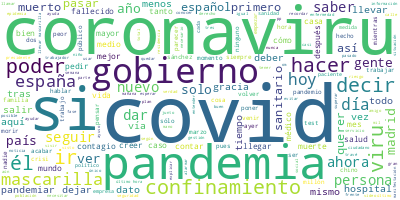

In [ ]:
#Wordcloud para comprobar tokens
from wordcloud import WordCloud
# Une las frases
long_string = ','.join(list(datos_ejercicio['lematizacion'].values))
# Genera un objecto WordCloud 
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
# Genera el wordcloud
wordcloud.generate(long_string)
# Visualizalo en una imagen
wordcloud.to_image()

 ### Subjetividad y polaridad

In [ ]:
def emoji_subjetividad(emojis):
  #Transformar a txto y traducir la descripsión del emoji
  emoji_description = emoji.demojize(emojis)
  emojis_desc_final = emoji_description.replace(":","")
  emojis_desc_final = emojis_desc_final.replace("_"," ")
  try:
    emojis_desc_final = TextBlob(emojis_desc_final).translate(from_lang='en', to = 'es')
  except:
    emojis_desc_final

  #Lemmatizar decripcion
  emojis_blob = emojis_desc_final.split()
  emojis_lemmas = [Word(x).lemmatize("v") for x in emojis_blob]
  emojis_lemmas = " ".join(emojis_lemmas)
  emojis_lemmas
  return emojis_lemmas

In [ ]:
def subjetividad(text):
  return TextBlob(text).sentiment.subjectivity

def polaridad(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
print(emoji_subjetividad('😁'))

cara radiante con ojos sonrientes


In [ ]:
datos_ejercicio["emoji_lemma"] = datos_ejercicio['emojis'].apply(lambda x: emoji_subjetividad(x))
datos_ejercicio["lemma_con_emoji"]= datos_ejercicio['lematizacion'] + ' ' + datos_ejercicio["emoji_lemma"]

In [ ]:
datos_ejercicio["subjetividad"] = datos_ejercicio["lemma_con_emoji"].apply(lambda x: subjetividad(x))
datos_ejercicio["polaridad"] = datos_ejercicio["lemma_con_emoji"].apply(lambda x: polaridad(x))

In [ ]:
datos_ejercicio

,tweet_id,tweet_text,label,set,char_len,emojis,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg,tweet_text_processed,tokenized,tokenized_clean,lematizacion,emoji_lemma,lemma_con_emoji,subjetividad,polaridad
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,87,[],0.0,0.0,0.0,CHINA: libera una pandemia EE.UU: libera OVNIS...,"[CHINA, :, libera, una, pandemia, EE.UU, :, li...","[china, libera, pandemia, libera, ovnis, argen...",chino libera pandemia libera ovnis argentino l...,,chino libera pandemia libera ovnis argentino l...,0.0,0.0
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,90,[],0.0,0.0,0.0,San Francisco (EEUU) hace 100 años tras vivir ...,"[San, Francisco, (, EEUU, ), hace, 100, años, ...","[san, francisco, eeuu, hace, 100, años, tras, ...",san francisco eeuu hacer 100 año tras vivir pa...,,san francisco eeuu hacer 100 año tras vivir pa...,0.0,0.0
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,95,[],0.0,0.0,0.0,Porfi poneos la mascarilla o tendremos 28 nuev...,"[Porfi, poneos, la, mascarilla, o, tendremos, ...","[porfi, poneos, mascarilla, 28, nuevas, cancio...",porfi poneo mascarilla 28 nuevo canción artist...,,porfi poneo mascarilla 28 nuevo canción artist...,0.0,0.0
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,225,[],0.0,0.0,0.0,El nuevo „covid normas y reglas recibimiento“ ...,"[El, nuevo, „, covid, normas, y, reglas, recib...","[nuevo, covid, normas, reglas, recibimiento, c...",nuevo covid norma regla recibimiento comercio ...,,nuevo covid norma regla recibimiento comercio ...,0.0,0.0
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,138,[],0.0,0.0,0.0,Si el confinamiento ha dejado algo tocada tu e...,"[Si, el, confinamiento, ha, dejado, algo, toca...","[si, confinamiento, dejado, tocada, estabilida...",si confinamiento dejado tocado estabilidad men...,,si confinamiento dejado tocado estabilidad men...,0.2,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1263939682662002689,#LoMásLeído | Los nuevos infectados de coronav...,0,valid,149,[],0.0,0.0,0.0,#LoMásLeído | Los nuevos infectados de coronav...,"[#LoMásLeído, |, Los, nuevos, infectados, de, ...","[nuevos, infectados, coronavirus, multiplican,...",nuevo infectado coronavirus multiplicar casi 2...,,nuevo infectado coronavirus multiplicar casi 2...,0.0,0.0
7996,1259976635891306516,Ayuso adjudica a dedo un contrato de 30.000 eu...,1,valid,138,[],0.0,0.0,0.0,Ayuso adjudica a dedo un contrato de 30.000 eu...,"[Ayuso, adjudica, a, dedo, un, contrato, de, 3...","[ayuso, adjudica, dedo, contrato, euros, hacer...",ayuso adjudico dedo contrato euros hacer vídeo...,,ayuso adjudico dedo contrato euros hacer vídeo...,0.0,0.0
7997,1277128552153055232,Meses encerrados. Se puede viajar a otras prov...,0,valid,280,[],0.0,0.0,0.0,Meses encerrados. Se puede viajar a otras prov...,"[Meses, encerrados, ., Se, puede, viajar, a, o...","[meses, encerrados, puede, viajar, provincias,...",mes encerrado poder viajar provincia ir restau...,,mes encerrado poder viajar provincia ir restau...,0.0,0.0
7998,1267915731422916613,El gobierno prohíbe por ley lis despidos duran...,0,valid,159,[🤮],0.0,0.0,0.0,El gobierno prohíbe por ley lis despidos duran...,"[El, gobierno, prohíbe, por, ley, lis, despido...","[gobierno, prohíbe, ley, lis, despidos, crisis...",gobierno prohíbir ley lis despido crisis coron...,vómitos de cara,gobierno prohíbir ley lis despido crisis coron...,0.0,0.0


## 4. Vectorización

In [ ]:
#Separo los subsets de validacion y train
subset_valid = datos_ejercicio[datos_ejercicio['set']=='valid']
subset_train = datos_ejercicio[datos_ejercicio['set']=='train']

In [ ]:
# BoW Features
vectorizador = TfidfVectorizer(min_df=0.01, ngram_range = (1,3))
vector_data_train = vectorizador.fit_transform(subset_train["lematizacion"])
vector_data_valid = vectorizador.transform(subset_valid["lematizacion"]) #El subset valid se transforma después de ajustar con el subset train para que tengan las mismas características

In [ ]:
vector_data_train

<6000x197 sparse matrix of type '<class 'numpy.float64'>'
	with 31132 stored elements in Compressed Sparse Row format>

In [ ]:
vector_data_valid

<2000x197 sparse matrix of type '<class 'numpy.float64'>'
	with 10237 stored elements in Compressed Sparse Row format>

## 5. Entrenamiento y evaluación de modelos


### Preparación de los datos

In [ ]:
extra_features_train = subset_train[['sent_emoji_pos','sent_emoji_neg','sent_emoji_neu','subjetividad','polaridad']]
extra_features_valid = subset_valid[['sent_emoji_pos','sent_emoji_neg','sent_emoji_neu','subjetividad','polaridad']]

In [ ]:
# Extraemos las etiquetas y las asignamos a la variable y
y = subset_train["label"].values.astype(np.float32) 
# Unimos las características TFIDF con las características previamente seleccionadas
# Extraemos los valores (values) de las extra_features, que es un dataframe  
X = sp.sparse.hstack((vector_data_train,extra_features_train.values),format='csr')

In [ ]:
#Lo mismo con el subset valid
y_valid = subset_valid["label"].values.astype(np.float32) 
X_valid = sp.sparse.hstack((vector_data_valid,extra_features_valid.values),format='csr')

In [ ]:
#Extrae nomobres de columnas
X_columns=list(vectorizador.get_feature_names_out())+extra_features_train.columns.tolist()

In [ ]:
print(X.shape)
print(X_valid.shape)

(6000, 202)
(2000, 202)


Antes se ha visto que las clases estaban desbalanceadas, por lo que se balancean con SMOTE

In [ ]:
smote = SMOTE(sampling_strategy = 0.5,random_state = 1234)#Se ajusta para que la clase minoritaria sea un 50% de la calse mayoritaria, para evitar introducir demasiados datos sintéticos
X_resampled, y_resampled = smote.fit_resample(X,y)

#Comprobación de tamaño de los datasets
print(f'El conjunto X sin balancear tiene: {X.shape}')
print(f'El conjunto y sin balancear tiene: {y.shape}')
print(f'El conjunto X tras balancear tiene: {X_resampled.shape}')
print(f'El conjunto y tras balancear tiene: {y_resampled.shape}')

El conjunto X sin balancear tiene: (6000, 202)
El conjunto y sin balancear tiene: (6000,)
El conjunto X tras balancear tiene: (6910, 202)
El conjunto y tras balancear tiene: (6910,)


In [ ]:
#Separo train-test el subset de train
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, stratify = y_resampled, random_state=1234)

In [ ]:
def eval_model (models, score, X, y):
  #Instancio KF
  kf = KFold(n_splits=5, shuffle = True, random_state = 123)

  results = []
  names = []

  #Para cada modelo
  for name, model in models:
    cv_results = cross_val_score(model, X, y, cv = kf, scoring = score, verbose = False)

    #Guardar resultado
    results.append(cv_results)
    names.append(name)

    #Print de resultados
    #print(f'Metrica {str(score)}, Kfold')
    #print(f'{name}: {cv_results.mean()}, {cv_results.std()}')

  return results, names

### Primer análisis de modelos

In [ ]:
#Modelos que se van a probar
models = [
    ('Logistic', LogisticRegression()),
    ('GaussianNB', GaussianNB()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('ExtraTrees', ExtraTreesClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVC', SVC())
]

eval_score = 'accuracy'

In [ ]:
results, names = eval_model(models, eval_score, X_resampled.toarray(), y_resampled)

In [ ]:
#Plot de los resultados
accuracy_tuples = [(name, result.mean()) for name, result in zip(names, results)]

accuracy_tuples = sorted(accuracy_tuples, key = lambda x: x[1], reverse = False)

ordered_names = [tup[0] for tup in accuracy_tuples]

ordered_accuracy = [tup[1] for tup in accuracy_tuples]

<function matplotlib.pyplot.show(close=None, block=None)>

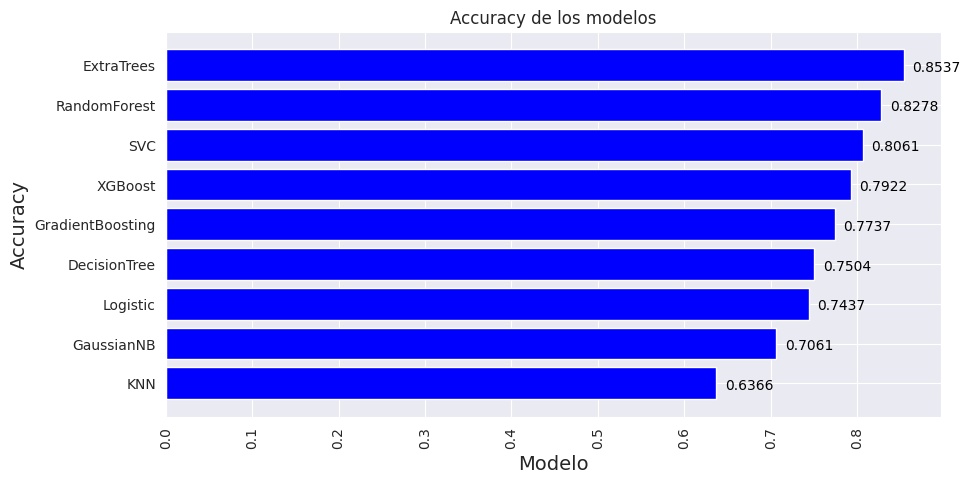

In [ ]:
plt.figure(figsize = (10,5))
plt.barh(ordered_names, ordered_accuracy, color = 'b')
plt.title('Accuracy de los modelos')
plt.xlabel('Modelo', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.xticks(rotation = 90)
for i, v in enumerate(ordered_accuracy):
  plt.text(v + 0.01, i - 0.15, str(round(v,4)), color='black', fontsize = 10)
plt.show

De los modelos que se han explorado, los tres que mejor se comportan son ExtraTrees, RandomForest y SVC. Para la etapa posterior voy a trabajar con ExtraTrees y SVC ya que son modelos más distintos entre ellos.


### Extra Trees Clssifier

In [ ]:
def tune_model(X, y, model, param_grid):
    
    # Definir los parametros a ajustar
    param_grid = param_grid
    
    #KFold 
    
    kfold = KFold(n_splits=5,
                  shuffle=True,
                  random_state=11)
    
    # Crear una instancia del clasificador
    model = model
    
    # Crear una instancia de GridSearchCV con el clasificador y los parametros a ajustar
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    
    # Ajustar el GridSearchCV en los datos
    model = grid_search.fit(X, y)
    
    # Devolver los mejores parametros encontrados
    
    print('Best parameters', grid_search.best_params_)
    print('Best score', grid_search.best_score_)
    
    return model

In [ ]:
#Instancio el modelo
Extra_Tree = ExtraTreesClassifier()

#Parametros para el GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Split quality criterion
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}


Best parameters {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score 0.9085082917845673

In [ ]:
##GridSearch para el tuneo de hiperparámetros, desactivada para evitar la espera al ejecutar el cuaderno, los mejores parámetros obtenidos están en la celda de encima
#model1_extra_tree = tune_model(X_train.toarray(), y_train, Extra_Tree, param_grid)

In [ ]:
#Instancio el modelo con los parametros obtenidos en el GridSearch
extra_tree_hypertuned = ExtraTreesClassifier(
    criterion='gini',
    max_depth = None,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split = 2,
    n_estimators = 100)

In [ ]:
#Ajuste del modelo
model1_extra_tree = extra_tree_hypertuned.fit(X_train.toarray(), y_train)

In [ ]:
#Obtención de las predicciones
y_pred = extra_tree_hypertuned.predict(X_test)

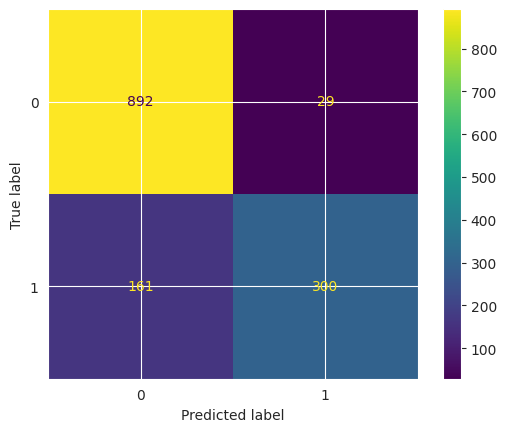

In [ ]:
#Matriz de confusion del modelo
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
#Reporte del modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.90       921
         1.0       0.91      0.65      0.76       461

    accuracy                           0.86      1382
   macro avg       0.88      0.81      0.83      1382
weighted avg       0.87      0.86      0.86      1382



Con el modelo ajustado se observa que los valores de accuracy en el subset de entrenamiento han aumentado, sin embargo, el valor de recall para la predicción de 1 es algo bajo, probablemente debido al escalado de los datos.

### SVC

In [ ]:
#Instancio el modelo
SVC_model = SVC()

#Parametros para el GridSearch
param_grid = {
    'C': [0.1, 1, 10, 20, 50],  # Penalty parameter C
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [1, 2, 3] #Degree for poly kernel
}

In [ ]:
#model2_SVC = tune_model(X_train.toarray(), y_train, SVC_model, param_grid)

Best parameters {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score 0.8838715819975622

In [ ]:
#Modelo con los parametros obtenidos en el gridSearch
SCV_model_hypertuned = SVC(
    C = 10,
    degree = 1,
    gamma = 'scale',
    kernel = 'rbf'
)

In [ ]:
#Ajuste del modelo
model2_SVC = SCV_model_hypertuned.fit(X_train.toarray(), y_train)

In [ ]:
#Obtención de predicciones
y_pred_model2 = model2_SVC.predict(X_test.toarray())

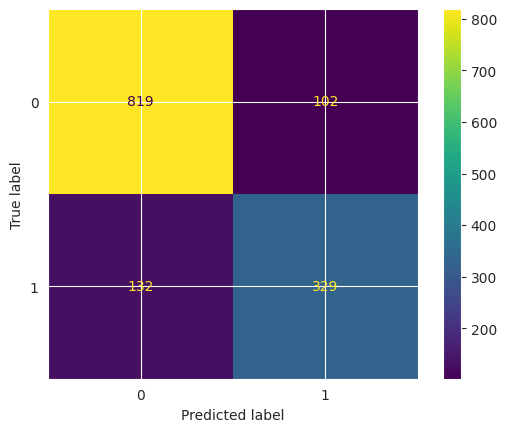

In [ ]:
#Matriz de confusion del modelo
cm_model2 = confusion_matrix(y_test, y_pred_model2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_model2)
disp.plot()

In [ ]:
#Report
print(classification_report(y_test, y_pred_model2))

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88       921
         1.0       0.76      0.71      0.74       461

    accuracy                           0.83      1382
   macro avg       0.81      0.80      0.81      1382
weighted avg       0.83      0.83      0.83      1382



## Validación

El entrenamiento y validación del modelo final se va a realizar con el modelo de ExtraTrees, ya que los valores de accuracy y f1score son superiores al modelo de SVC, aunque el valor de recall es mejor para svc

In [ ]:
#Ajuste del modelo con todos los datos del subset train con oversampling
final_model = extra_tree_hypertuned.fit(X_resampled.toarray(), y_resampled)

In [ ]:
#Prediccion final frente a los datos de validación
y_pred_final = final_model.predict(X_valid.toarray())

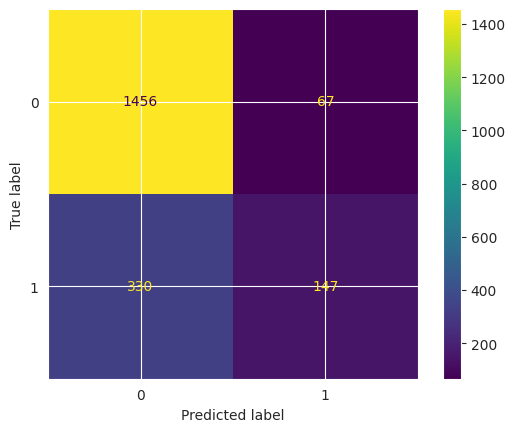

In [ ]:
#Matriz de confusion del modelo
cm_final = confusion_matrix(y_valid, y_pred_final)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_final)
disp.plot()

In [ ]:
print(classification_report(y_valid, y_pred_final))

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88      1523
         1.0       0.69      0.31      0.43       477

    accuracy                           0.80      2000
   macro avg       0.75      0.63      0.65      2000
weighted avg       0.78      0.80      0.77      2000



In [ ]:
print(f'Accuracy score: {accuracy_score(y_valid, y_pred_final)}')
print(f'Recall score: {recall_score(y_valid, y_pred_final)}')
print(f'Recall score: {f1_score(y_valid, y_pred_final)}')

Accuracy score: 0.8015
Recall score: 0.3081761006289308
Recall score: 0.4254703328509407


En el modelo final el accuracy disminuye, además el valor de recall y f1 score son sorprendentemente bajos. El modelo falla al predecir las etiquetas 1, probablemente debido a que el dataset estaba desbalanceado y se han generado datos sintéticamente, por lo que a la hora de enfrentarlo a los datos reales, el modelo sobreestima la cantidad de etiquetas 1, que en los datos reales es menor.

## Prueba pipeline smote


Prueba aplicando SMOTE dentro de un pipeline en el CV. De esta forma en cada split se deberían oversamplear los subset de train y dejar igual los de validacion, esto sumado a utilizar f1 como metrica debería ayudar a mejorar los resultados de los modelos de cara a la predicción correcta de la clase minoritaria. También se ha cambiado el Kfold por un RepeatedStratifiedKFold para que realice 5 iteraciones de 5 splits en los que mantenga la proporcion de los datos.

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from imblearn.pipeline import Pipeline

def eval_model (models, X, y):
  #Instancio KF
  kf = RepeatedStratifiedKFold(n_splits=5, n_repeats = 5, random_state = 1234)

  results = []
  names = []

  #Para cada modelo
  for name, model in models:
    #Instancio el modelo y SMOTE
    model = model
    smote = SMOTE(sampling_strategy=0.5, random_state = 1234)
    #Creo el pipeline
    pipeline = Pipeline([('over',smote),('model', model)])
    #Aplico CV sobre el conjunto X,y utilizando el pipeline
    cv_results = cross_val_score(pipeline, X, y, cv = kf, scoring = 'f1', verbose = False)

    #Guardar resultado
    results.append(cv_results)
    names.append(name)

    #Print de resultados
    #print(f'Metrica {str(score)}, Kfold')
    #print(f'{name}: {cv_results.mean()}, {cv_results.std()}')

  return results, names

In [ ]:
#Modelos
models = [
    ('Logistic', LogisticRegression()),
    ('GaussianNB', GaussianNB()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('ExtraTrees', ExtraTreesClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVC', SVC())
]

In [ ]:
results, names = eval_model(models, X.toarray(), y)

In [ ]:
accuracy_tuples = [(name, result.mean()) for name, result in zip(names, results)]

accuracy_tuples = sorted(accuracy_tuples, key = lambda x: x[1], reverse = False)

ordered_names = [tup[0] for tup in accuracy_tuples]

ordered_accuracy = [tup[1] for tup in accuracy_tuples]

<function matplotlib.pyplot.show(close=None, block=None)>

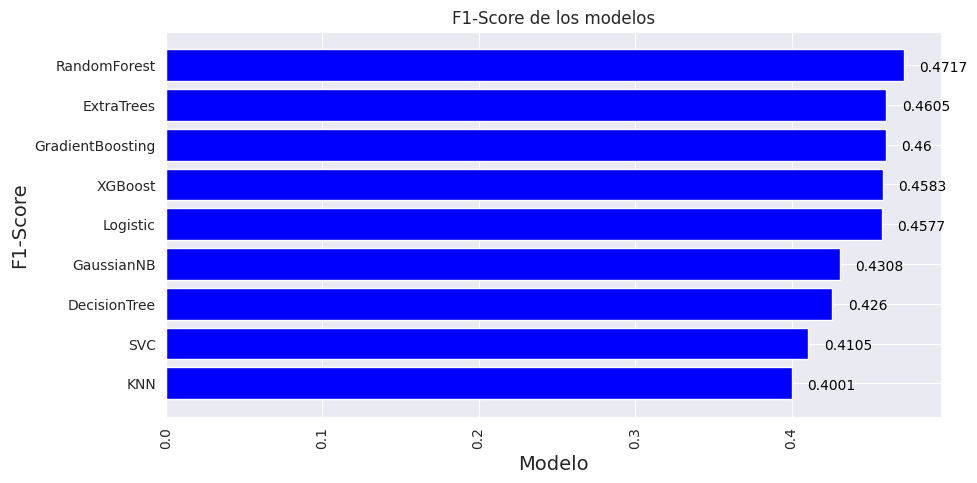

In [ ]:
plt.figure(figsize = (10,5))
plt.barh(ordered_names, ordered_accuracy, color = 'b')
plt.title('F1-Score de los modelos')
plt.xlabel('Modelo', fontsize = 14)
plt.ylabel('F1-Score', fontsize = 14)
plt.xticks(rotation = 90)
for i, v in enumerate(ordered_accuracy):
  plt.text(v + 0.01, i - 0.15, str(round(v,4)), color='black', fontsize = 10)
plt.show

En primer momento, se ve que el random forest es mejor que extratrees. 
Voy a ajustar los hiperparámetros de este para ver si se mejoran los modelos.

In [ ]:
#Función de tuneo de hiperparámetros modificada para aplicar el pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
def tune_model(X, y, model, param_grid):
    
    # Definir los parametros a ajustar
    param_grid = param_grid
    
    #KFold 
    
    kf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1234)#No utilizo RepeatedStratifiedKFold porque el proceso era demasiado lento, pero sería más correcto aplicar este
    #Instancio el modelo y SMOTE
    model = model
    smote = SMOTE(sampling_strategy=0.5, random_state = 1234)
    #Creo el pipeline
    pipeline = Pipeline([('over',smote),('model', model)])
    
    # Crear una instancia de GridSearchCV con el clasificador y los parametros a ajustar
    grid_search = RandomizedSearchCV(pipeline, param_grid, cv=kf, scoring='f1', n_jobs=-1)
    
    # Ajustar el GridSearchCV en los datos
    model = grid_search.fit(X, y)
    
    # Devolver los mejores parametros encontrados
    
    print('Best parameters', grid_search.best_params_)
    print('Best score', grid_search.best_score_)
    print(grid_search.best_estimator_)
    
    return model

In [ ]:
param_grid = {
    'model__n_estimators': [10,100, 200],  # Number of trees in the forest
    'model__criterion': ['gini', 'entropy'],  # Split quality criterion
    'model__max_depth': [None, 5, 10],  # Maximum depth of the tree
    'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'model__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'model__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'model__class_weight': [None, 'balanced', 'balanced_subsample'],  # Weighting scheme for the classes
    'model__bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'model__random_state': [42]  # Random seed for reproducibility
}

In [ ]:
rf = RandomForestClassifier()

In [ ]:
##Tuneo de hiperparámetros
#model3_rf = tune_model(X.toarray(), y, rf, param_grid)

Best parameters {'model__random_state': 42, 'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': None, 'model__criterion': 'gini', 'model__class_weight': 'balanced_subsample', 'model__bootstrap': True}
Best score 0.5003028112524172
Pipeline(steps=[('over', SMOTE(random_state=1234, sampling_strategy=0.5)),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_features='log2', min_samples_leaf=4,
                                        n_estimators=200, random_state=42))])


In [ ]:
#modelo con los parámetros obtenidos
model = RandomForestClassifier(
    n_estimators =200,
    criterion ='gini',
    max_depth =None,
    min_samples_split =2,
    min_samples_leaf=4,
    max_features ='log2',
    class_weight ='balanced_subsample', #Importante para los subsets desbalanceados
    bootstrap =True,
    random_state = 42
)
smote = SMOTE(sampling_strategy=0.5, random_state = 1234)
#Creo el pipeline
pipeline = Pipeline([('over',smote),('model', model)])

In [ ]:
prueba_pipeline_model = pipeline.fit(X.toarray(), y)

In [ ]:
#Prediccion
y_pred_pipeline = prueba_pipeline_model.predict(X_valid.toarray())

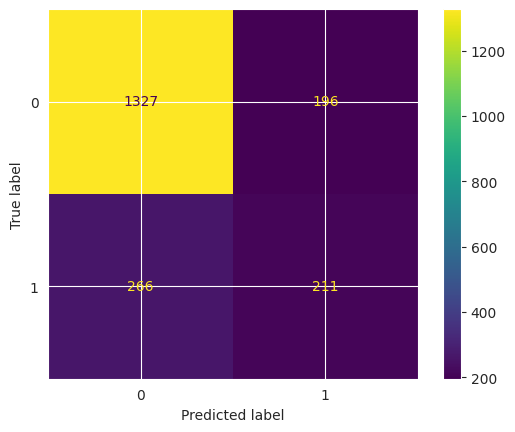

In [ ]:
#Matriz de confusion del modelo
cm_pipeline = confusion_matrix(y_valid, y_pred_pipeline)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_pipeline)
disp.plot()

In [ ]:
#Classification report
print(classification_report(y_valid, y_pred_pipeline))

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1523
         1.0       0.52      0.44      0.48       477

    accuracy                           0.77      2000
   macro avg       0.68      0.66      0.66      2000
weighted avg       0.76      0.77      0.76      2000



In [ ]:
#Métricas
print(f'Accuracy score: {accuracy_score(y_valid, y_pred_pipeline)}')
print(f'Recall score: {recall_score(y_valid, y_pred_pipeline)}')
print(f'F1 score: {f1_score(y_valid, y_pred_pipeline)}')

Accuracy score: 0.769
Recall score: 0.44234800838574423
F1 score: 0.4773755656108597


En comparación con los valores obtenidos en el modelo final de ExtraTrees, el modelo obtenido de RandomForest utilizando el pipeline, este último se ha disminuido un poco el accuracy, pero el valor de recall ha mejorado en 0.13 y el valor de F1score en 0.05. Por lo que parece que el modelo se comporta mejor a la hora de enfrentarlo a los datos reales.